In [8]:
import time

import numpy as np
import torch

from src.data import batch_dataset, load_data, split_data
from src.lstm import MCDLSTM, train_mcdlstm
from torch.utils.data import TensorDataset, DataLoader

from matplotlib import pyplot as plt
import pandas as pd

df = load_data()
dataset = split_data(
    df,
    without_cols=[
        "Timestamp",
        "Light1",
        "Light2",
        "Light3",
        "Light4",
    ],
    scale="normalize",
)
seq_dataset = batch_dataset(dataset, sequence_length=10, overlap_series=True)

(x_train, y_train), (x_test, y_test) = dataset
(seq_x_train, seq_y_train), (seq_x_test, seq_y_test) = seq_dataset

## Z regresją

 48%|████▊     | 24/50 [08:35<09:18, 21.50s/it]

Early stop.
Best dev loss: 0.2394975401159417
MSE: 0.239, r2: 0.844, f1 macro: 0.357
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       702
         1.0       0.00      0.00      0.00         0
         2.0       0.28      0.77      0.41        93
         3.0       0.12      0.02      0.03       192

    accuracy                           0.78       987
   macro avg       0.35      0.44      0.36       987
weighted avg       0.76      0.78      0.75       987



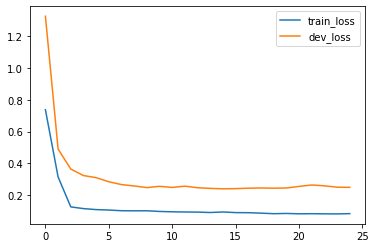

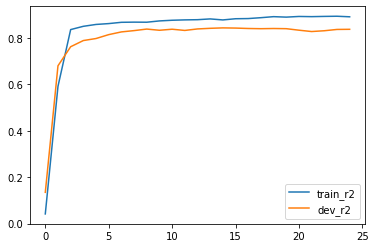

In [11]:
device = 'cuda:0'

train_ds = TensorDataset(seq_x_train, seq_y_train)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

test_ds = TensorDataset(seq_x_test, seq_y_test)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

mcdLSTM_regr = MCDLSTM(no_layers=2, input_size=12, hidden_dim=32, output_dim=1, drop_prob=0.25, device=device).to(device)

mse, r2, f1, report = train_mcdlstm(mcdLSTM_regr, train_dl, test_dl, regression=True,
                                    epochs=50, lr=0.00001, patience=10,
                                    save_prefix='models/lstm_model_'+str(int(time.time())),
                                    print_chart=True, print_progress=False, device=device)

print(f'MSE: {mse:.3f}, r2: {r2:.3f}, f1 macro: {f1:.3f}')
print(report)


## Z klasyfikacją

In [6]:
device = 'cuda:0'

train_ds = TensorDataset(seq_x_train, seq_y_train)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

test_ds = TensorDataset(seq_x_test, seq_y_test)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

mcdLSTM_clf = MCDLSTM(no_layers=2, input_size=12, hidden_dim=32, output_dim=4, drop_prob=0.25, device=device).to(device)

mse, r2, f1, report = train_mcdlstm(mcdLSTM_clf, train_dl, test_dl, regression=False,
                                    epochs=50, lr=0.00001, patience=10,
                                    save_prefix='models/lstm_model_'+str(int(time.time())),
                                    print_chart=True, print_progress=False, device=device)

print(f'MSE: {mse:.3f}, r2: {r2:.3f}, f1 macro: {f1:.3f}')
print(report)

  0%|          | 0/50 [00:04<?, ?it/s]

KeyboardInterrupt



# Niepewności (regresja)

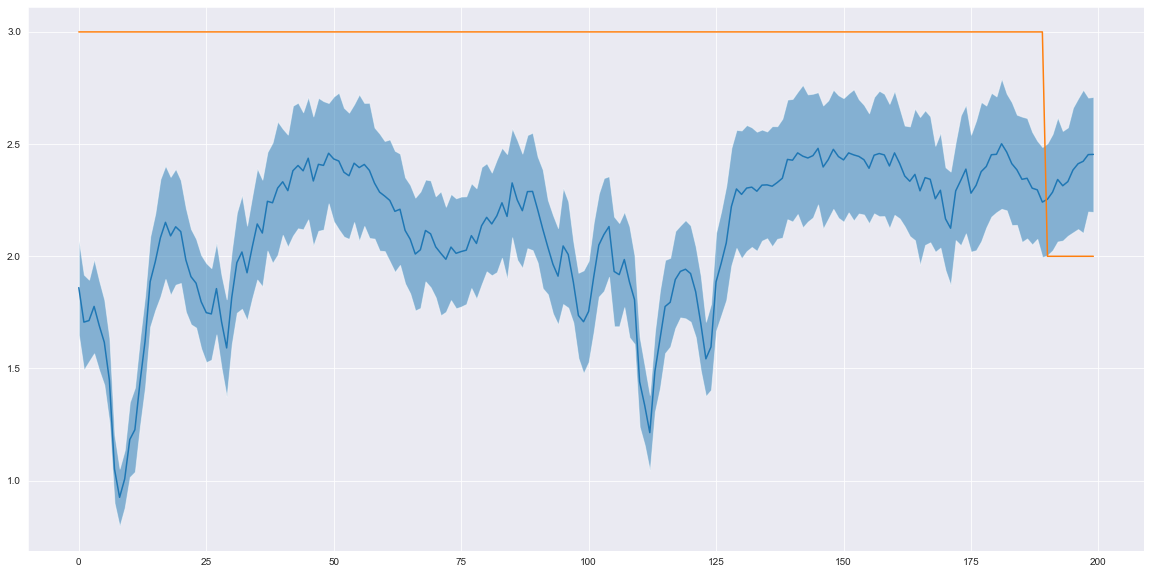

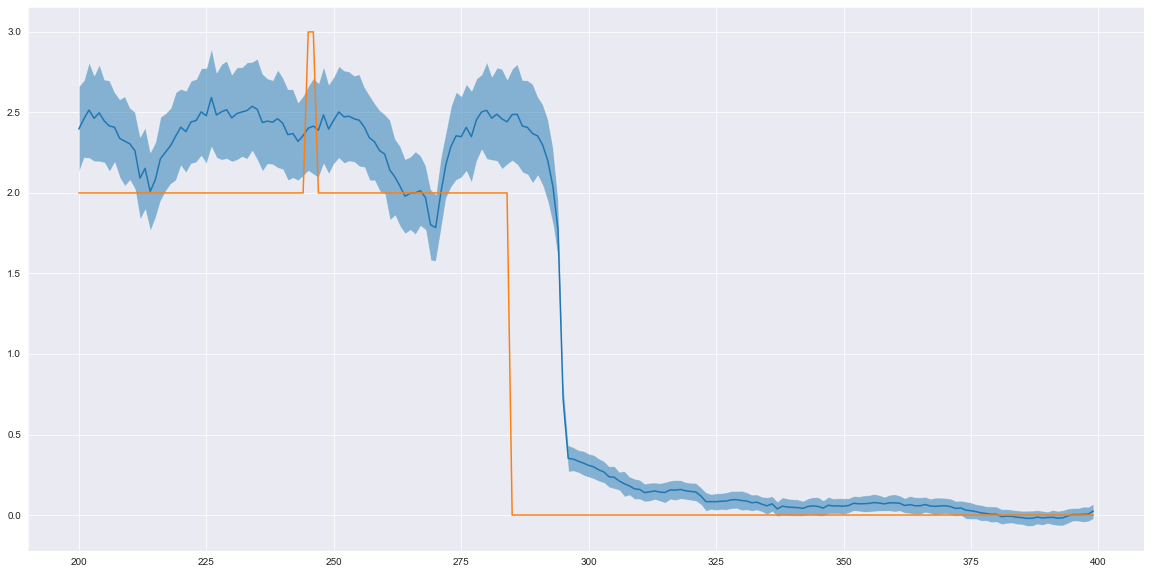

In [18]:
device='cuda:0'

mcdLSTM_regr = MCDLSTM(no_layers=2, input_size=12, hidden_dim=32, output_dim=1, drop_prob=0.25, device=device).to(device)
best_state = torch.load('models/lstm_model_regr_state_dict.pt', map_location=device)
mcdLSTM_regr.load_state_dict(best_state)

test_ds = TensorDataset(seq_x_test, seq_y_test)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

outs = []
ys = []
for x, y in test_dl:
    outs.append(np.array(mcdLSTM_regr.estimate_distributions(x.to(device), n_samples=100)).transpose())
    ys.extend(y.numpy()[:,-1])

outs = np.vstack(outs)
outs_df = pd.DataFrame({'mean': outs[:,0], 'std': outs[:,1], 'trues': ys})

outs_df_1 = outs_df.iloc[0:200,:]
plt.figure(figsize=(20,10))
plt.plot(outs_df_1.index, outs_df_1['mean'])
plt.plot(outs_df_1.index, outs_df_1['trues'])
plt.fill_between(outs_df_1.index, y1=outs_df_1['mean']-outs_df_1['std'],
                y2=outs_df_1['mean'] + outs_df_1['std'], alpha=.5)

outs_df_2 = outs_df.iloc[200:400,:]
plt.figure(figsize=(20,10))
plt.plot(outs_df_2.index, outs_df_2['mean'])
plt.plot(outs_df_2.index, outs_df_2['trues'])
plt.fill_between(outs_df_2.index, y1=outs_df_2['mean']-outs_df_2['std'],
                 y2=outs_df_2['mean'] + outs_df_2['std'], alpha=.5)

## Prawdopodobieństwa klasy (klasyfikacja)

<function matplotlib.pyplot.legend(*args, **kwargs)>

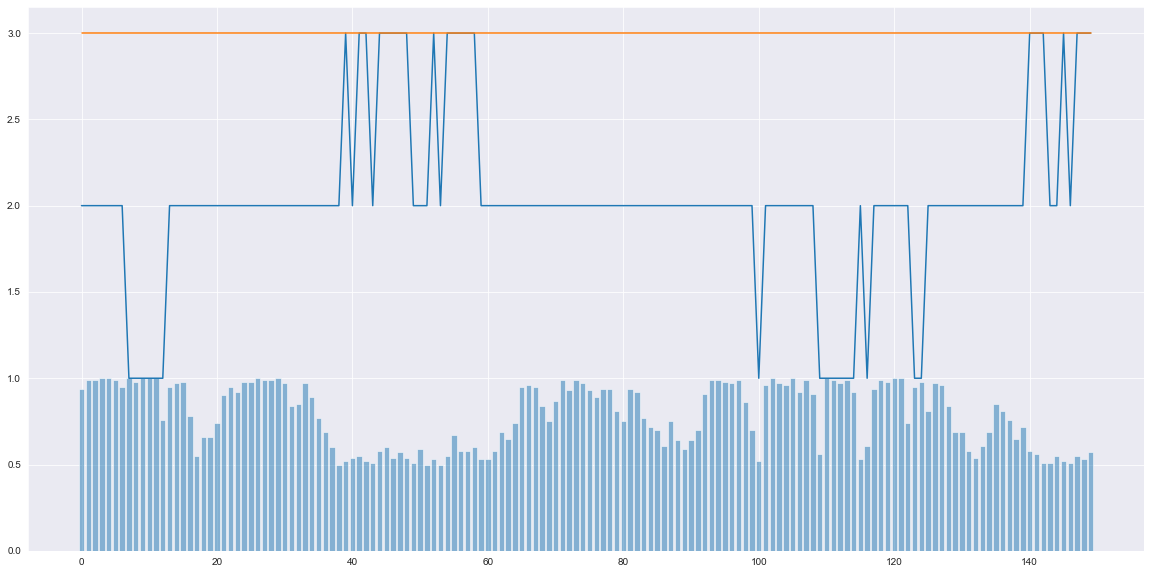

In [30]:
test_ds = TensorDataset(seq_x_test, seq_y_test)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

mcdLSTM_clf = MCDLSTM(no_layers=2, input_size=12, hidden_dim=32, output_dim=4, drop_prob=0.25, device=device).to(device)
best_state = torch.load('models/lstm_model_clf_state_dict.pt', map_location=device)
mcdLSTM_clf.load_state_dict(best_state)

outs = []
ys = []
for x, y in test_dl:
    outs.append(np.array(mcdLSTM_clf.estimate_distributions(x.to(device), n_samples=100)))
    ys.extend(y.numpy()[:,-1])

outs = np.vstack(outs)

outs_df = pd.DataFrame({'pred': np.argmax(outs, axis=1),
                        'proba': np.max(outs, axis=1),
                        'true': ys})

outs_df = outs_df[0:150]
plt.figure(figsize=(20,10))
plt.plot(outs_df.index, outs_df['pred'], label='true')
plt.plot(outs_df.index, outs_df['true'], label='pred')
plt.bar(outs_df.index, outs_df['proba'], alpha=.5)
plt.legend